"1" represents spam, while "0" represents not spam.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


<Axes: xlabel='spam', ylabel='count'>

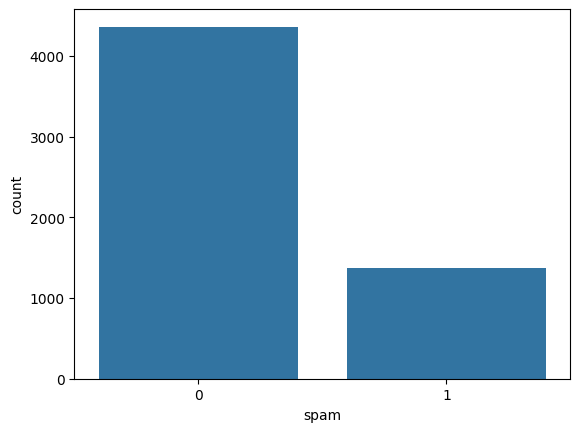

In [4]:
sns.countplot(x=df['spam'])

In [5]:
df['spam'].value_counts()

spam
0    4360
1    1368
Name: count, dtype: int64

In [6]:
df['text'][0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [7]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

In [11]:
preprocess_text(df['text'][0])

'subject naturally irresistible corporate identity lt really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good product effective business organization practicable aim hotat nowadays market promise marketing effort become much effective list clear benefit creativeness hand made original logo specially done reflect distinctive company image convenience logo stationery provided format easy use content management system letsyou change website content even structure promptness see logo draft within three business day affordability marketing break make gap budget satisfaction guaranteed provide unlimited amount change extra fee surethat love result collaboration look portfolio interested'

In [13]:
df['text'] = df['text'].apply(preprocess_text)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(max_features=5000)


In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['spam'],test_size=0.2,random_state=42)

In [17]:
x_train = vec.fit_transform(x_train)
x_test = vec.transform(x_test)

In [18]:
x_train.shape,x_test.shape

((4582, 5000), (1146, 5000))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [20]:
models = {
    "RandomForestClassifier":RandomForestClassifier(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "XGBClassifier":XGBClassifier(),
    "LogisticRegression":LogisticRegression(),
    "MultinomialNB":MultinomialNB()
}

In [21]:
params = {
    "RandomForestClassifier": {
        "n_estimators": [50, 100, 150],
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [3, 5, 8]
    },
    "DecisionTreeClassifier": {
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 4, 6],
        "criterion": ["gini", "entropy"]
    },
    "XGBClassifier": {
        "n_estimators": [100,150, 50],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 1, 0.1]
    },
    "LogisticRegression": {
        "solver": ["lbfgs", "saga"],
        "C": [0.1, 0.5, 1.0, 2.0],
        "penalty": ["l1", "l2"]
    },
    "MultinomialNB": {
        "alpha": [0.1, 0.5, 1.0, 2.0],  
        "fit_prior": [True, False]
    }
}

In [23]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,classification_report
report = {}
for i in range(len(models)):
    name = list(models.keys())[i]
    model = list(models.values())[i]
    param = params[name]
    print(f"-------Enter {name}------")
    random = RandomizedSearchCV(estimator=model,param_distributions=param,scoring='accuracy',cv=2,n_iter=20)
    random.fit(x_train,y_train)
    report[name] = random.best_params_
    y_pred = random.predict(x_test)
    print("Accuracy :-",accuracy_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    print(f"-------Exit {name}------")

-------Enter RandomForestClassifier------
Accuracy :- 0.8577661431064573
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       856
           1       1.00      0.44      0.61       290

    accuracy                           0.86      1146
   macro avg       0.92      0.72      0.76      1146
weighted avg       0.88      0.86      0.84      1146

-------Exit RandomForestClassifier------
-------Enter DecisionTreeClassifier------
Accuracy :- 0.9485165794066318
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       856
           1       0.87      0.94      0.90       290

    accuracy                           0.95      1146
   macro avg       0.92      0.95      0.93      1146
weighted avg       0.95      0.95      0.95      1146

-------Exit DecisionTreeClassifier------
-------Enter XGBClassifier------
Accuracy :- 0.9799301919720768
              precision    recall  f1-score   support


In [24]:
report['LogisticRegression']

{'solver': 'saga', 'penalty': 'l2', 'C': 2.0}

In [25]:
model = LogisticRegression(solver='saga',penalty='l2',C=2)

In [26]:
model.fit(x_train,y_train)

LogisticRegression(C=2, solver='saga')

In [27]:
import pickle
with open('model.pkl','wb') as file:
    pickle.dump(model,file)

In [28]:
with open('vector.pkl','wb') as file:
    pickle.dump(vec,file)

In [30]:
a = vec.transform([preprocess_text(df['text'][120])])

In [32]:
model.predict(a)

array([1])

In [33]:
df['spam'][120]

np.int64(1)

In [40]:
df['spam'][1368]

np.int64(0)

In [41]:
df['text'][1368]

'subject hello guy bugging completed questionnaire one page bio statement thought business edu new economy record incorrect please ship response want put everything together next week ship back everyone questionnaire attached well copy bio page michael froehls two somewhat different approach idea latter introduce panelist give background approaching issue discus also provide copy attendee use material personal introduction opening panel discussion thanks look forward seeing two week john waco background mf doc jmartinbiosketch doc questionnaire doc john martin carr p collins chair finance finance department baylor university po box waco tx office fax j martin baylor edu web http hsb baylor edu html martinj home html'